## Calculate land cover trends

Prepare temporal statistics (trend, intercept, stdev) data at the co2-data resolution

Land cover types: 
- individual types 
- total forest 
- shrub+savanna 
- grassland 
- cropland 
- grassland+cropland+CropNatMosiac  


In [ ]:
# Import packages
import os
import rioxarray as rio
import xarray as xr
from xarrayutils.utils import linear_trend

### General Settings

In [ ]:
output_dir = '../data_output/'
inversion = 's99'
lc_proc_path = '/Users/moyanofe/BigData/GeoSpatial/LandCover/LandCover_MODIS_MCD12/MCD12C1_proc'
file_in = 'MCD12C1.A2001-2021.061.LCtype1.All.lr.nc'

### Load data

In [ ]:
# Load the co2 data ----
file_co2amp_trend = os.path.join(output_dir, 'co2invSeasAmpTrend_' + inversion + '.nc')
co2amp = rio.open_rasterio(file_co2amp_trend)
co2amp.rio.write_crs(4326, inplace=True)

### Preparing LC data

In [ ]:

# Index for MCD12C1 Land_Cover_Type_1_Percent: IGBP land cover types
lcIndex = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
lcNames = ['Water', 'ENForest', 'EBForest', 'DNForest', 'DBForest', 
    'MixForest', 'ClosedShrub', 'OpenShrub', 'WoodySavanna',
    'Savanna', 'Grassland', 'PermWetland', 'Cropland',
    'Urban', 'CropNatMosiac', 'PermSnowIce', 'Barren']

### Calculating trends

The linear_trend function from xarrayutils.utils returns an xarray dataset with variables including slope, intercept, p-value


In [38]:
# Load the low resolution LC data

filepath_in = os.path.join(lc_proc_path, file_in)
ds_lc = rio.open_rasterio(filepath_in, masked=True)


# Calculate trends and intercept for each LC type

ds_lcTrends = xr.Dataset()

for i in range(len(lcNames)): # [0]: # range(len(lcNames)):
    # print(lcNames[i])
    da_lc = ds_lc[lcNames[i]]
    # Calculate trends
    lc_trend = linear_trend(da_lc, 'time')
    lc_trend = lc_trend.to_array()
    lc_trend.attrs['units'] = 'percent/y'  # Should change to an array with units for each variable
    lc_trend.attrs['long_name'] = 'Trend in ' + lcNames[i] + ' cover' # Should change to an array with names for each variable
    lc_trend.rio.write_crs(4326, inplace=True)
    ds_lcTrends[lcNames[i]] = lc_trend


# Calculate trends for grouped LC types

lcNamesNew = ['Forest', 'Shrub', 'GrassCrop']
ds_lc['Forest'] = ds_lc['ENForest'] + ds_lc['EBForest'] + ds_lc['DNForest'] + ds_lc['DBForest'] + ds_lc['WoodySavanna']
ds_lc['Shrub'] = ds_lc['ClosedShrub'] + ds_lc['OpenShrub']
ds_lc['GrassCrop'] = ds_lc['Grassland'] + ds_lc['Cropland'] + ds_lc['CropNatMosiac']


for i in range(len(lcNamesNew)): # [0]: # range(len(lcNamesNew)):
    # print(lcNamesNew[i])
    da_lc = ds_lc[lcNamesNew[i]]
    # Calculate trends
    lc_trend = linear_trend(da_lc, 'time')
    lc_trend = lc_trend.to_array()
    lc_trend.attrs['units'] = 'percent/y'  # Should change to an array with units for each variable
    lc_trend.attrs['long_name'] = 'Trend in ' + lcNamesNew[i] + ' cover' # Should change to an array with names for each variable
    lc_trend.rio.write_crs(4326, inplace=True)
    ds_lcTrends[lcNamesNew[i]] = lc_trend


# Save trends to file

file_out = os.path.join(output_dir, 'MCD12C1.A2001-2021.061.LCtype1.lr.Trends.nc')
ds_lcTrends.to_netcdf(file_out)

### Plots

/var/folders/8f/pswsw93d6klgw34_s99kdcgn1tv7l7/T/ipykernel_9136/1683942489.py:31: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(p1, label=plotdata.attrs['units'])


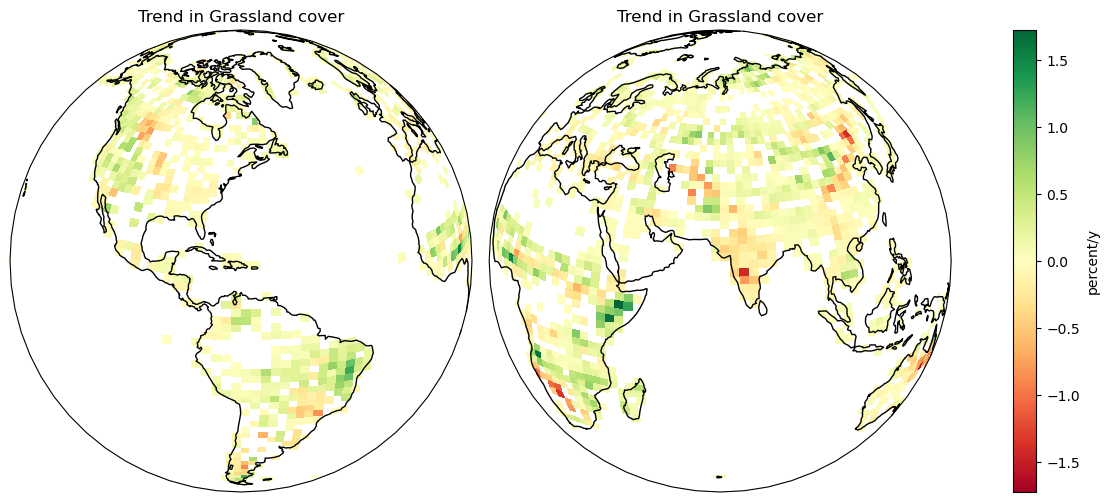

In [44]:
# Map plot of lc trends globally

# Import plotting packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ['Water', 'ENForest', 'EBForest', 'DNForest', 'DBForest', 
#     'MixForest', 'ClosedShrub', 'OpenShrub', 'WoodySavanna',
#     'Savanna', 'Grassland', 'PermWetland', 'Cropland',
#     'Urban', 'CropNatMosiac', 'PermSnowIce', 'Barren']

# Select data to plot
lc = 'Grassland'
p_lim = 0.1

plotdata = ds_lcTrends[lc].sel(variable='slope')
p_val = ds_lcTrends[lc].sel(variable='p_value')

fig = plt.figure(figsize=[16,6])
ax1 = fig.add_subplot(121, projection = ccrs.Orthographic(-70, 20), facecolor="white")
ax2 = fig.add_subplot(111, projection = ccrs.Orthographic(70, 20), facecolor="white")
plotdata_sig = plotdata.where(p_val < p_lim) # Change the p+value limit to filter for trend significance
p1 = plotdata_sig.plot(ax = ax1, transform=ccrs.PlateCarree(), cmap='RdYlGn', add_colorbar=False)
p2 = plotdata_sig.plot(ax = ax2, transform=ccrs.PlateCarree(), cmap='RdYlGn', add_colorbar=False)
ax1.set_global()
ax1.coastlines()
ax1.set_title(plotdata.attrs['long_name'])
ax2.set_global()
ax2.coastlines()
ax2.set_title(plotdata.attrs['long_name'])
plt.colorbar(p1, label=plotdata.attrs['units'])
# plt.colorbar(p2, label=co2InvT.isel(time=0).attrs['units'])
plt.show()